# Image Segmentation with Unet
Unet is a model designed to use fewer annotated data samples than other techniques, such as Mask RCNN. It relies on data augmentation to be more efficient in that respect. It is composed of a contracting path and a symmetric extracting path. Its purpose in this exercise is to identify cell membranes from pictures of neuronal tissues Hence, the output will be a series of masks that superimpose on the original image pixel by pixel and highlight what is in or out of a cell.

In [7]:
# usual imports
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np

np.random.seed(42)

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

# data generators for image processing
from data import *

## Build Unet Model
From http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
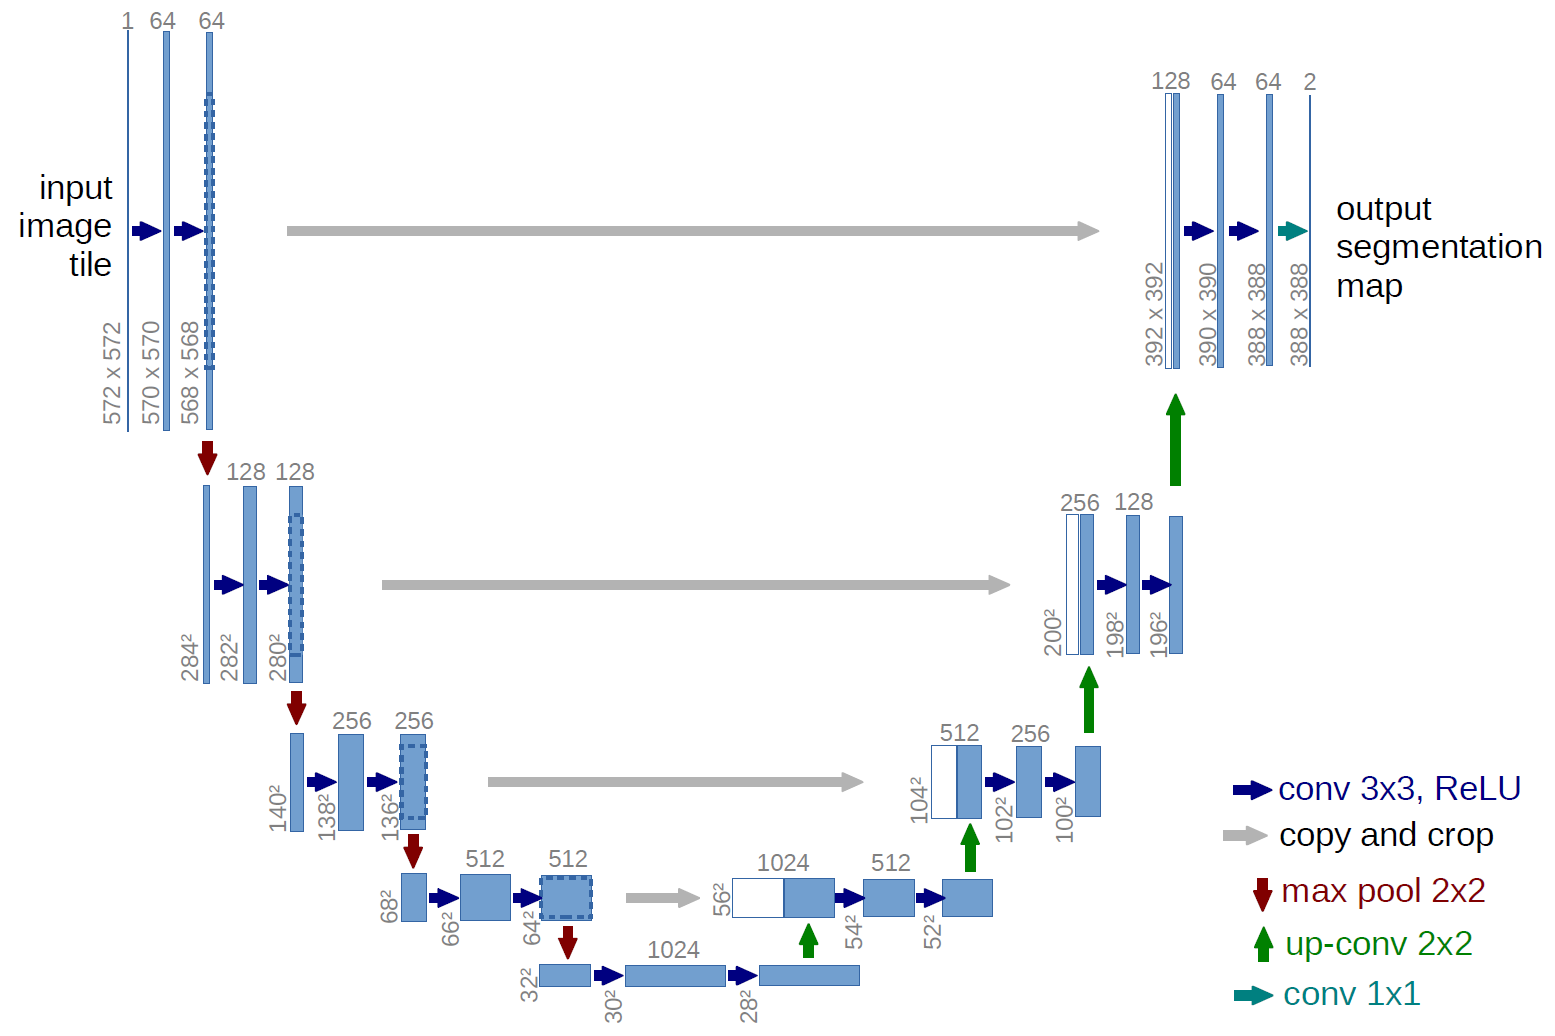

In [8]:
def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

## Train the Unet
Cell pictures are in the folder 'membrane', divided in train and test datasets. They have already been pre-processed for size, equalization etc.
The "labels" are pictures of the masks to be identified.
The task can be thought of as binary classification: a pixel may belong to a membrane or not.
The shape of image and mask are the same: (batch_size, rows, cols, channel = 1)

### Train with data generator
There are only 30 pictures. We rely on data augmentation to improve the robustness of the model.

In [9]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
trainGen = trainGenerator(2,'data/membrane/train','image','label',data_gen_args,save_to_dir = None)

In [10]:
model = unet()
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(trainGen,steps_per_epoch=1000,epochs=5,callbacks=[model_checkpoint])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_25[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_26[0][0]                  
__________________________________________________________________________________________________
conv2d_27 

Epoch 1/5
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
1000/1000 [==============================] - 451s 451ms/step - loss: 0.2842 - acc: 0.8918

Epoch 00001: loss improved from inf to 0.28423, saving model to unet_membrane.hdf5
Epoch 2/5
1000/1000 [==============================] - 450s 450ms/step - loss: 0.2260 - acc: 0.9248

Epoch 00002: loss improved from 0.28423 to 0.22603, saving model to unet_membrane.hdf5
Epoch 3/5
1000/1000 [==============================] - 450s 450ms/step - loss: 0.2047 - acc: 0.9350

Epoch 00003: loss improved from 0.22603 to 0.20471, saving model to unet_membrane.hdf5
Epoch 4/5
1000/1000 [==============================] - 450s 450ms/step - loss: 0.1876 - acc: 0.9430

Epoch 00004: loss improved from 0.20471 to 0.18764, saving model to unet_membrane.hdf5
Epoch 5/5
1000/1000 [==============================] - 450s 450ms/step - loss: 0.1737 - acc: 0.9491

Epoch 00005: loss improved from 0.18764 to 0.17374, saving model to une

### Test model and save predicted results

In [11]:
testGen = testGenerator("data/membrane/test")
model = unet()
model.load_weights("unet_membrane.hdf5")
results = model.predict_generator(testGen,30,verbose=1)
saveResult("data/membrane/test",results)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 640         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 

30/30 [==============================] - 5s 177ms/step


W1010 05:46:12.388568 140107047757568 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W1010 05:46:12.482993 140107047757568 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W1010 05:46:12.578138 140107047757568 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W1010 05:46:12.669796 140107047757568 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W1010 05:46:12.758370 140107047757568 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W1010 05:46:12.854617 140107047757568 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress 

## Show the results
The generators resize all images to 256x256. We'll expand to 512x512 for visibility and show them. If the prediction is accurate, cell membranes will be marked in black.

(512, 512) (256, 256)


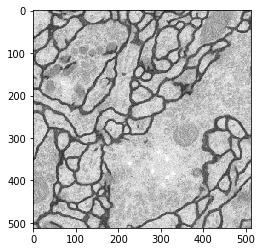

In [20]:
from PIL import Image

background = Image.open("data/membrane/test/1.png")
overlay = Image.open("data/membrane/test/1_predict.png")

background = background.convert("RGBA")
overlay = overlay.convert("RGBA")

print (background.size, overlay.size)

overlay=overlay.resize((512,512))

new_img = Image.blend(background, overlay, 0.5)

%matplotlib inline
from matplotlib.pyplot import imshow
imshow(np.asarray(new_img))